In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
dataset1 = '/home/user/257/10000.txt'
dataset2 = '/home/user/257/song_data.csv'

temp_df1 = pd.read_csv(dataset1, sep="\t", names =["user_id", "song_id", "listen_count"])
temp_df2 = pd.read_csv(dataset2)
#temp_df1.head()
#temp_df2.head()


final_df = pd.merge(temp_df1, temp_df2.drop_duplicates(['song_id']), on="song_id", how="left")
final_df = final_df.head(10000)

In [4]:
final_df["user_id"] = pd.Categorical(final_df["user_id"])
final_df['user_id'] = final_df["user_id"].cat.codes

final_df["song_id"] = pd.Categorical(final_df["song_id"])
final_df['song_id'] = final_df["song_id"].cat.codes

final_df.sort_values(['user_id'], ascending=[1])

final_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,259,71,1,The Cove,Thicker Than Water,Jack Johnson,0
1,259,219,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,259,388,1,Stronger,Graduation,Kanye West,2007
3,259,394,1,Constellations,In Between Dreams,Jack Johnson,2005
4,259,635,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [5]:
df = final_df[['user_id', 'song_id', 'listen_count']]
df.head()

,user_id,song_id,listen_count
0,259,71,1
1,259,219,2
2,259,388,1
3,259,394,1
4,259,635,1


In [6]:
df['Ratings'] = np.random.randint(1, 6, df.shape[0])

/home/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [7]:
songs_df = df[['user_id', 'song_id', 'Ratings']]
songs_df.head()

,user_id,song_id,Ratings
0,259,71,1
1,259,219,1
2,259,388,5
3,259,394,1
4,259,635,1


In [8]:
n_users = songs_df.user_id.unique().shape[0]
n_items = songs_df.song_id.unique().shape[0]
n_rating = songs_df.Ratings.unique().shape[0]

print ('%i unique users' %n_users)
print ('%i unique songs' %n_items)
print ('%i unique ratings' %n_rating)

365 unique users
5175 unique songs
5 unique ratings


In [9]:
songs_df['Ratings'].describe()

count    10000.000000
mean         3.000900
std          1.421725
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: Ratings, dtype: float64

Text(0.5,1,'Distribution of ratings')

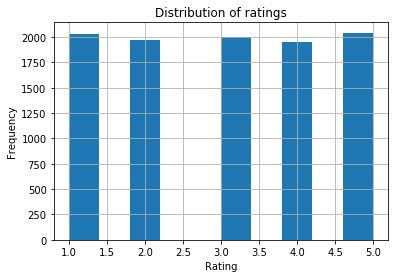

In [15]:
songs_df['Ratings'].hist(grid=True)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of ratings')

Text(0.5,1,'Distribution of normalized ratings')

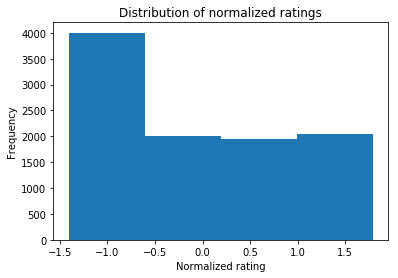

In [17]:
from sklearn.preprocessing import scale
binwidth = 0.8
data = scale(songs_df['Ratings'].astype(float))
plt.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth))    # Z-score normalization
plt.xlabel('Normalized rating')
plt.ylabel('Frequency')
plt.title('Distribution of normalized ratings')

In [18]:
ratings = songs_df.pivot(index = 'user_id', columns ='song_id', values = 'Ratings')


In [19]:
ratings = ratings.fillna(0)

In [20]:
ratings = ratings.as_matrix()

In [21]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print ('percentage of user-items that have a rating: {:.2f}%'.format(sparsity))

percentage of user-items that have a rating: 0.53%


In [22]:
def train_test_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy() #don't do train=ratings, other wise, ratings becomes empty
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0])>=35:# 35 seems to be best, it depends on sparsity of your user-item matrix
            val_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=15, #tweak this, 15 seems to be optimal
                                        replace=False)
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    print(validation.shape)
    return train, validation

In [23]:
train, val = train_test_split(ratings)

(365, 5175)


In [24]:
from numpy import linalg as LA

In [25]:
def cos_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
        norms=np.array(LA.norm(ratings)*LA.norm(ratings.T))
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
        norms = np.array(LA.norm(ratings.T)*LA.norm(ratings))
    return (sim / norms )

In [26]:
user_similarity = cos_similarity(train, kind='user')
item_similarity=cos_similarity(train, kind='item')

In [27]:
def predict_nobias(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += item_bias[np.newaxis, :]
        
    return pred

In [28]:
user_prediction2 = predict_nobias(train, user_similarity, kind='user')
item_prediction2 = predict_nobias(train, item_similarity, kind='item')

In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [30]:
print ('User-based bias-adjusted CF RMSE: %.2f' %rmse(user_prediction2, val))
print ('Item-based bias-adjusted CF RMSE: %.2f' %rmse(item_prediction2, val))

User-based bias-adjusted CF RMSE: 3.24
Item-based bias-adjusted CF RMSE: 3.24


In [31]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [32]:
u, s, vt = svds(train, k = 20)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

In [33]:
print ('matrix-factorization CF RMSE: %.2f' %rmse(X_pred, val))

matrix-factorization CF RMSE: 3.27


In [34]:
def prediction(P,Q):
    return np.dot(P.T,Q)

In [91]:
lmbda = 0.4 # Regularization parameter
k = 25 #tweak this parameter
m, n = train.shape  # Number of users and items
n_epochs = 20  # Number of epochs
alpha=0.01  # Learning rate

P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix

In [92]:
train_errors = []
val_errors = []

#Only consider items with ratings 
users,items = train.nonzero()      
for epoch in range(n_epochs):
    for u, i in zip(users,items):
        e = train[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient update
        P[:,u] += alpha * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
        Q[:,i] += alpha * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent item feature matrix
    
    train_rmse = rmse(prediction(P,Q),train)
    val_rmse = rmse(prediction(P,Q),val) 
    train_errors.append(train_rmse)
    val_errors.append(val_rmse)

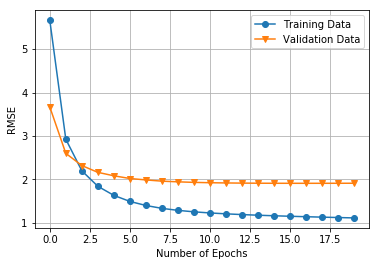

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), val_errors, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

In [56]:
SGD_prediction=prediction(P,Q)

In [51]:
estimation= SGD_prediction[val.nonzero()]
ground_truth = val[val.nonzero()]
results=pd.DataFrame({'prediction':estimation, 'actual rating':ground_truth})

In [52]:
results.head(10)

,actual rating,prediction
0,2.0,2.254228
1,2.0,4.048134
2,1.0,2.588182
3,4.0,2.093088
4,3.0,2.297462
5,5.0,4.004066
6,3.0,3.769384
7,3.0,2.532663
8,5.0,4.339424
9,1.0,3.116233
